In [1]:
#GENERAL
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
# IMAGE PROCESS
import cv2
# MACHINE LEARNING
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
tf.keras.backend.set_floatx('float32')

# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

plt.style.use("dark_background")

# BMW CHALLENGE: Automated quality assessment
The following notebook demonstrates a hybrid quantum algorithm which detects surface cracks from the [surface-crack-detection dataset](https://www.kaggle.com/arunrk7/surface-crack-detection).

# Pre Processing

To make the 227 x 227 pixel images compatible with quantum computing, we apply a threshold and downsample the image to be 8 x 8 pixels.


We have modified the preprocessing from: https://www.kaggle.com/brsdincer/surface-crack-detection-end-to-end-process by Baris Dincer.

In [2]:
Surface_Data = Path("surface_crack_detection")

In [3]:
Surface_JPG_Path = list(Surface_Data.glob(r"*/*.jpg"))

In [4]:
Surface_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Surface_JPG_Path))

TO SERIES

In [5]:
Surface_JPG_Path_Series = pd.Series(Surface_JPG_Path,name="JPG").astype(str)
Surface_Labels_Series = pd.Series(Surface_Labels,name="CATEGORY")

TO DATAFRAME

In [6]:
Main_Surface_Data = pd.concat([Surface_JPG_Path_Series,Surface_Labels_Series],axis=1)

In [7]:
print(Main_Surface_Data.head(-1))

                                                JPG  CATEGORY
0      surface_crack_detection/Positive/16679_1.jpg  Positive
1        surface_crack_detection/Positive/04354.jpg  Positive
2        surface_crack_detection/Positive/02725.jpg  Positive
3      surface_crack_detection/Positive/11369_1.jpg  Positive
4        surface_crack_detection/Positive/19463.jpg  Positive
...                                             ...       ...
39994    surface_crack_detection/Negative/09669.jpg  Negative
39995    surface_crack_detection/Negative/11026.jpg  Negative
39996    surface_crack_detection/Negative/05053.jpg  Negative
39997    surface_crack_detection/Negative/15240.jpg  Negative
39998    surface_crack_detection/Negative/03422.jpg  Negative

[39999 rows x 2 columns]


TO SHUFFLE

In [8]:
Main_Surface_Data = Main_Surface_Data.sample(frac=1).reset_index(drop=True)

In [9]:
print(Main_Surface_Data.head(-1))

                                                JPG  CATEGORY
0        surface_crack_detection/Negative/06881.jpg  Negative
1        surface_crack_detection/Positive/01226.jpg  Positive
2        surface_crack_detection/Negative/04640.jpg  Negative
3      surface_crack_detection/Positive/14413_1.jpg  Positive
4        surface_crack_detection/Negative/09942.jpg  Negative
...                                             ...       ...
39994    surface_crack_detection/Positive/00931.jpg  Positive
39995    surface_crack_detection/Positive/19417.jpg  Positive
39996  surface_crack_detection/Positive/10024_1.jpg  Positive
39997    surface_crack_detection/Negative/18820.jpg  Negative
39998    surface_crack_detection/Positive/08143.jpg  Positive

[39999 rows x 2 columns]


# VISUALIZATION

LABELS

In [10]:
Positive_Surface = Main_Surface_Data[Main_Surface_Data["CATEGORY"] == "Positive"]
Negative_Surface = Main_Surface_Data[Main_Surface_Data["CATEGORY"] == "Negative"]

Positive_Surface = Positive_Surface.reset_index()
Negative_Surface = Negative_Surface.reset_index()

In [11]:
def simple_vision(path):
    figure = plt.figure(figsize=(8,8))
    
    Reading_Img = cv2.imread(path)
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    plt.xlabel(Reading_Img.shape)
    plt.ylabel(Reading_Img.size)
    plt.imshow(Reading_Img)


In [12]:
def greyscale_vision(path):
    figure = plt.figure(figsize=(8,8))
    
    Reading_Img = cv2.imread(path)
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.IMREAD_GRAYSCALE)
    
    plt.xlabel(Reading_Img.shape)
    plt.ylabel(Reading_Img.size)
    plt.imshow(Reading_Img)


In [13]:
def threshold_vision(path):
    figure = plt.figure(figsize=(8,8))
    
    Reading_Img = cv2.imread(path)
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    _,Threshold_Img = cv2.threshold(Reading_Img,130,255,cv2.THRESH_BINARY_INV)
    
    plt.xlabel(Threshold_Img.shape)
    plt.ylabel(Threshold_Img.size)
    plt.imshow(Threshold_Img)

## SIMPLE VISION

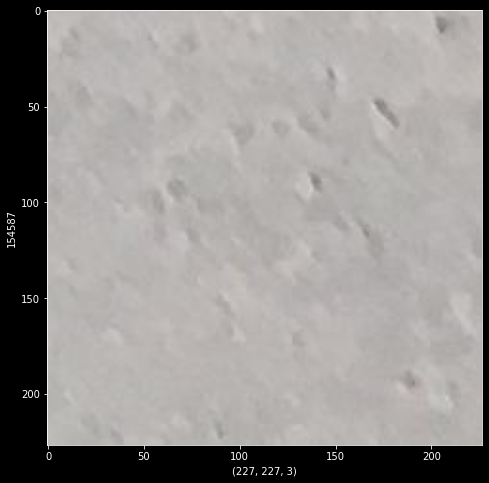

In [14]:
simple_vision(Main_Surface_Data["JPG"][4])

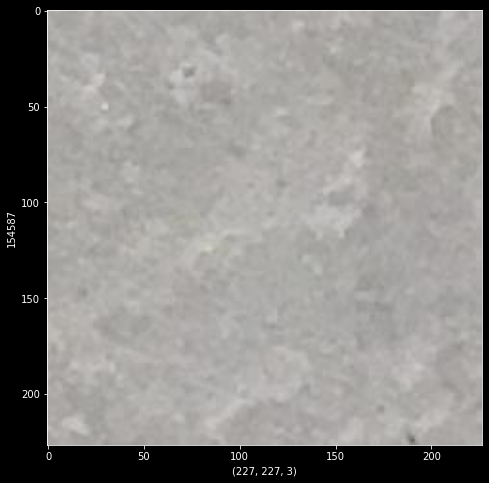

In [15]:


simple_vision(Main_Surface_Data["JPG"][2])



### Positive Surfaces

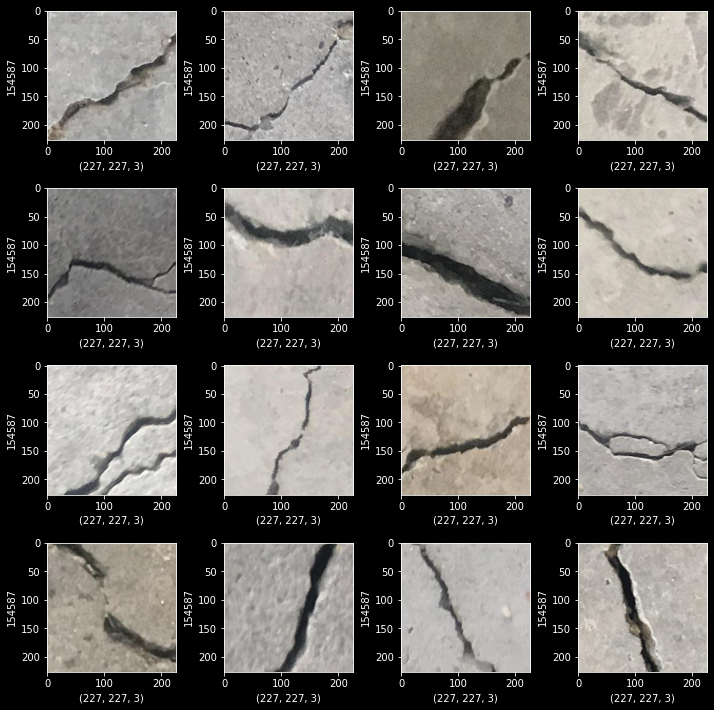

In [16]:
figure,axis = plt.subplots(4,4,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Positive_Surface["JPG"][indexing])
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    operations.set_xlabel(Reading_Img.shape)
    operations.set_ylabel(Reading_Img.size)
    operations.imshow(Reading_Img)
    
plt.tight_layout()
plt.show()

### Negative Surfaces

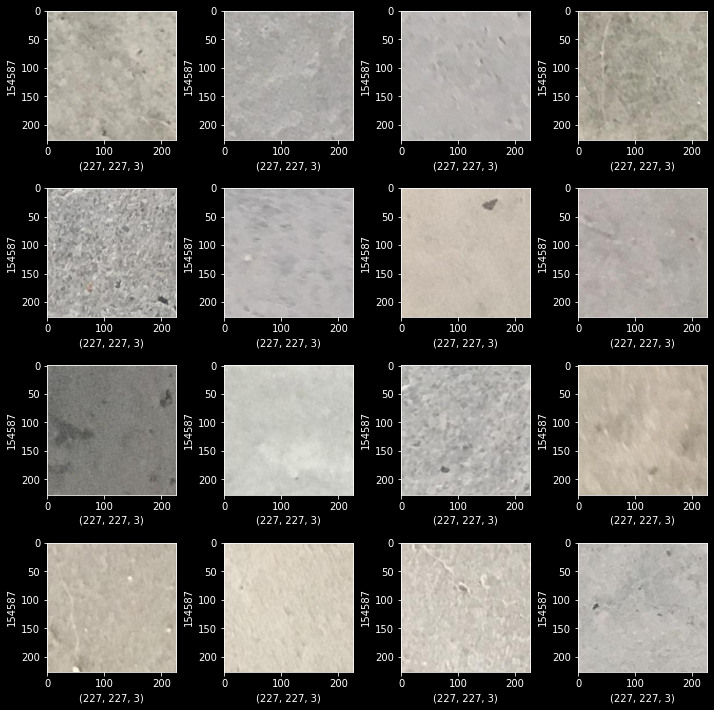

In [17]:
figure,axis = plt.subplots(4,4,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Negative_Surface["JPG"][indexing])
    Reading_Img = cv2.cvtColor(Reading_Img,cv2.COLOR_BGR2RGB)
    
    operations.set_xlabel(Reading_Img.shape)
    operations.set_ylabel(Reading_Img.size)
    operations.imshow(Reading_Img)
    
plt.tight_layout()
plt.show()

## THRESHOLD VISION

We'll use threshold vision.

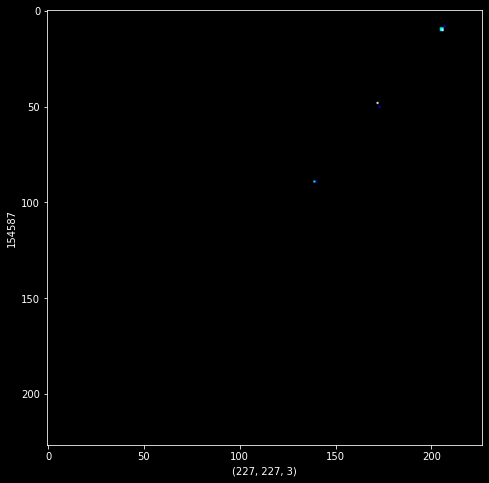

In [18]:
threshold_vision(Main_Surface_Data["JPG"][4])

### Positive Surfaces

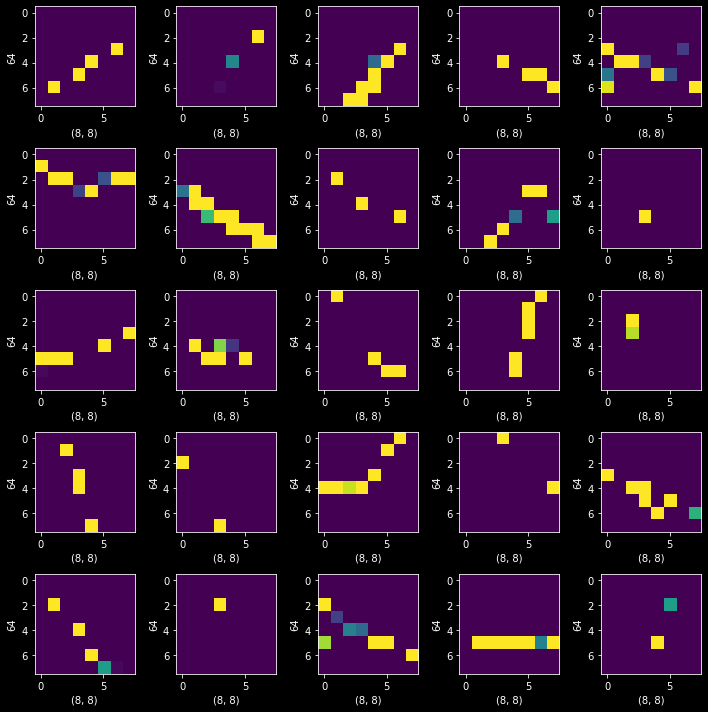

In [19]:
figure,axis = plt.subplots(5,5,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    
    Reading_Img = cv2.imread(Positive_Surface["JPG"][indexing], cv2.IMREAD_GRAYSCALE)
    _,Threshold_Img = cv2.threshold(Reading_Img,100,255,cv2.THRESH_BINARY_INV)
    # dsize must be an 8x8 for the PQC.
    dsize = (8, 8)

    # resize image
    Threshold_Img = cv2.resize(Threshold_Img, dsize,cv2.INTER_AREA)
    
    operations.set_xlabel(Threshold_Img.shape)
    operations.set_ylabel(Threshold_Img.size)
    operations.imshow(Threshold_Img)
    
plt.tight_layout()
plt.show()

### Negative Surfaces

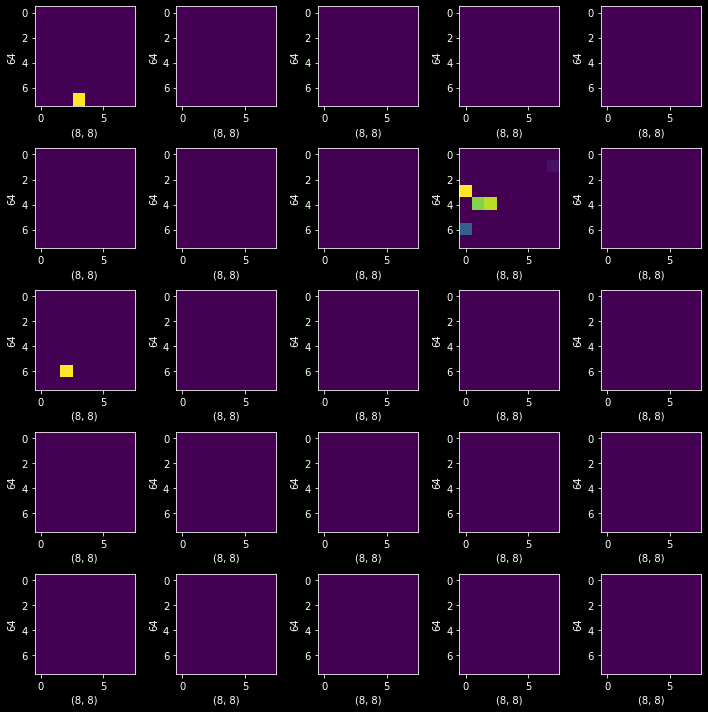

In [20]:
figure,axis = plt.subplots(5,5,figsize=(10,10))

for indexing,operations in enumerate(axis.flat):
    Reading_Img = cv2.imread(Negative_Surface["JPG"][indexing], cv2.IMREAD_GRAYSCALE)
    _,Threshold_Img = cv2.threshold(Reading_Img,100,255,cv2.THRESH_BINARY_INV)
    # dsize must be an 8x8 for the PQC.
    dsize = (8, 8)

    # resize image
    Threshold_Img = cv2.resize(Threshold_Img, dsize,cv2.INTER_AREA)
    operations.set_xlabel(Threshold_Img.shape)
    operations.set_ylabel(Threshold_Img.size)
    operations.imshow(Threshold_Img)
    
plt.tight_layout()
plt.show()

We note approximately 5% of the images as having contradicting labels when downsampled. While atraditional, some groups such as [Farhi et al.](https://arxiv.org/pdf/1802.06002.pdf) have removed them.

In [21]:
def normalize_data(data):
    #Create Array of pixel value
    if not np.any(data):
        # we have to make sure it is normalizable.
        data = data + 0.001
    arr_data = data.flatten()/max(data.flatten())
    encoding_data = np.array([np.round(x,6) for x in arr_data])
    sum_const =  np.sqrt(sum(encoding_data*encoding_data))
    encoding_norm = encoding_data/sum_const
    return encoding_norm

Test normalization

In [22]:
normalize_data(np.array([0,0]))

array([0.70710678, 0.70710678])

In [23]:
def preprocess_image(img_path: str) -> np.ndarray:
    """
    Applies a threshold, resize, then normalize.
    img_path: str =  image file path
    """
    # read image
    Reading_Img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # apply threshold
    _,Threshold_Img = cv2.threshold(Reading_Img,100,255,cv2.THRESH_BINARY_INV)
    # dsize must be an 8x8 for the PQC.
    dsize = (8, 8)
    # resize image
    Threshold_Img = cv2.resize(Threshold_Img, dsize,cv2.INTER_AREA)
    # normalize image
    Threshold_Img = normalize_data(Threshold_Img)
    return Threshold_Img

We will apply this to both the negative and positive surface datasets.


In [24]:
Main_Surface_Data['Image_Array']=Main_Surface_Data['JPG'].apply(preprocess_image)

We will used the resized arrays as our training feature and the categories as our targets.

In [28]:
X = Main_Surface_Data[['Image_Array','JPG']]
Y = Main_Surface_Data['CATEGORY']

Split the data into test and training sets

In [30]:
trainX, testX, trainy, testy = train_test_split(X, Y, test_size=0.3, random_state=42)

In [39]:
testX_tensor = np.array([tf.convert_to_tensor(image_array,dtype=np.float32) for image_array in testX['Image_Array']])
trainX_tensor = np.array([tf.convert_to_tensor(image_array,dtype=np.float32) for image_array in trainX['Image_Array']])

2021-09-24 09:41:15.524542: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
le = LabelEncoder()
le.fit(["Positive", "Negative"])

LabelEncoder()

In [41]:
testy_encoded = le.transform(testy)
trainy_encoded = le.transform(trainy)

In [47]:
trainy_encoded = tf.one_hot(trainy_encoded, depth=1)
testy_encoded = tf.one_hot(testy_encoded, depth=1)

In [48]:
n_qubits = 6
layers = 1
data_dimension = 2
dev = qml.device("braket.local.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(weights, inputs=None):
    inputs = normalize_data(inputs.numpy())
    inputs = tf.convert_to_tensor(inputs)
    qml.templates.AmplitudeEmbedding(features=inputs, wires=range(n_qubits),normalize=True)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [49]:
weight_shapes = {"weights": (layers,n_qubits,3)}

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64,activation='relu',input_dim=64, trainable=False))
model.add(qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
keras_layer (KerasLayer)     (None, 6)                 0 (unused)
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
Total params: 4,174
Trainable params: 14
Non-trainable params: 4,160
_________________________________________________________________


Here, we've reduced the model size to keep the training per epoch to around 2minutes. In the large model displayed in the readme, the epochs take around 30 minutes on a CPU.

In [53]:
history = model.fit(trainX_tensor[:100], trainy_encoded[:100], validation_data=(testX_tensor[:100], testy_encoded[:100]), epochs=7, batch_size=10,verbose=1)

Epoch 1/7
10/10 [==============================] - 140s 14s/step - loss: 0.5885 - accuracy: 0.8800 - val_loss: 0.5660 - val_accuracy: 0.7700
Epoch 2/7
10/10 [==============================] - 151s 16s/step - loss: 0.5420 - accuracy: 0.8500 - val_loss: 0.5480 - val_accuracy: 0.7200
Epoch 3/7
10/10 [==============================] - 104s 11s/step - loss: 0.5015 - accuracy: 0.8100 - val_loss: 0.5384 - val_accuracy: 0.7000
Epoch 4/7
10/10 [==============================] - 95s 10s/step - loss: 0.4732 - accuracy: 0.8100 - val_loss: 0.5272 - val_accuracy: 0.7400
Epoch 5/7
10/10 [==============================] - 101s 9s/step - loss: 0.4487 - accuracy: 0.8300 - val_loss: 0.5196 - val_accuracy: 0.7400
Epoch 6/7
10/10 [==============================] - 91s 9s/step - loss: 0.4291 - accuracy: 0.8500 - val_loss: 0.5126 - val_accuracy: 0.7300
Epoch 7/7
10/10 [==============================] - 103s 10s/step - loss: 0.4128 - accuracy: 0.8700 - val_loss: 0.5024 - val_accuracy: 0.7800


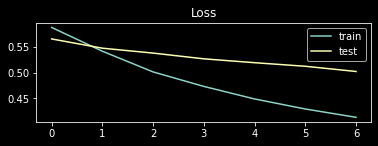

In [54]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

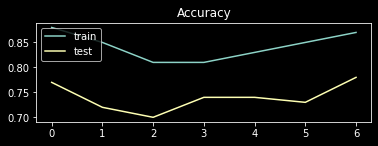

In [55]:
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

In [60]:
idx = 11500

predy = model.predict(testX_tensor[idx:])

In [61]:
from sklearn.metrics import multilabel_confusion_matrix
rounded_labels_pred=np.argmax(predy, axis=1)

rounded_labels_real=testy_encoded.numpy()[idx:]

/Users/rickyyoung/opt/anaconda3/envs/qBraid/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass display_labels=[0, 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


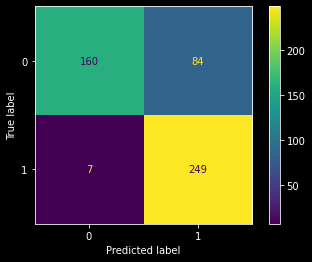

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(rounded_labels_real, rounded_labels_pred)

cm_display = ConfusionMatrixDisplay(cm, [0,1]).plot()

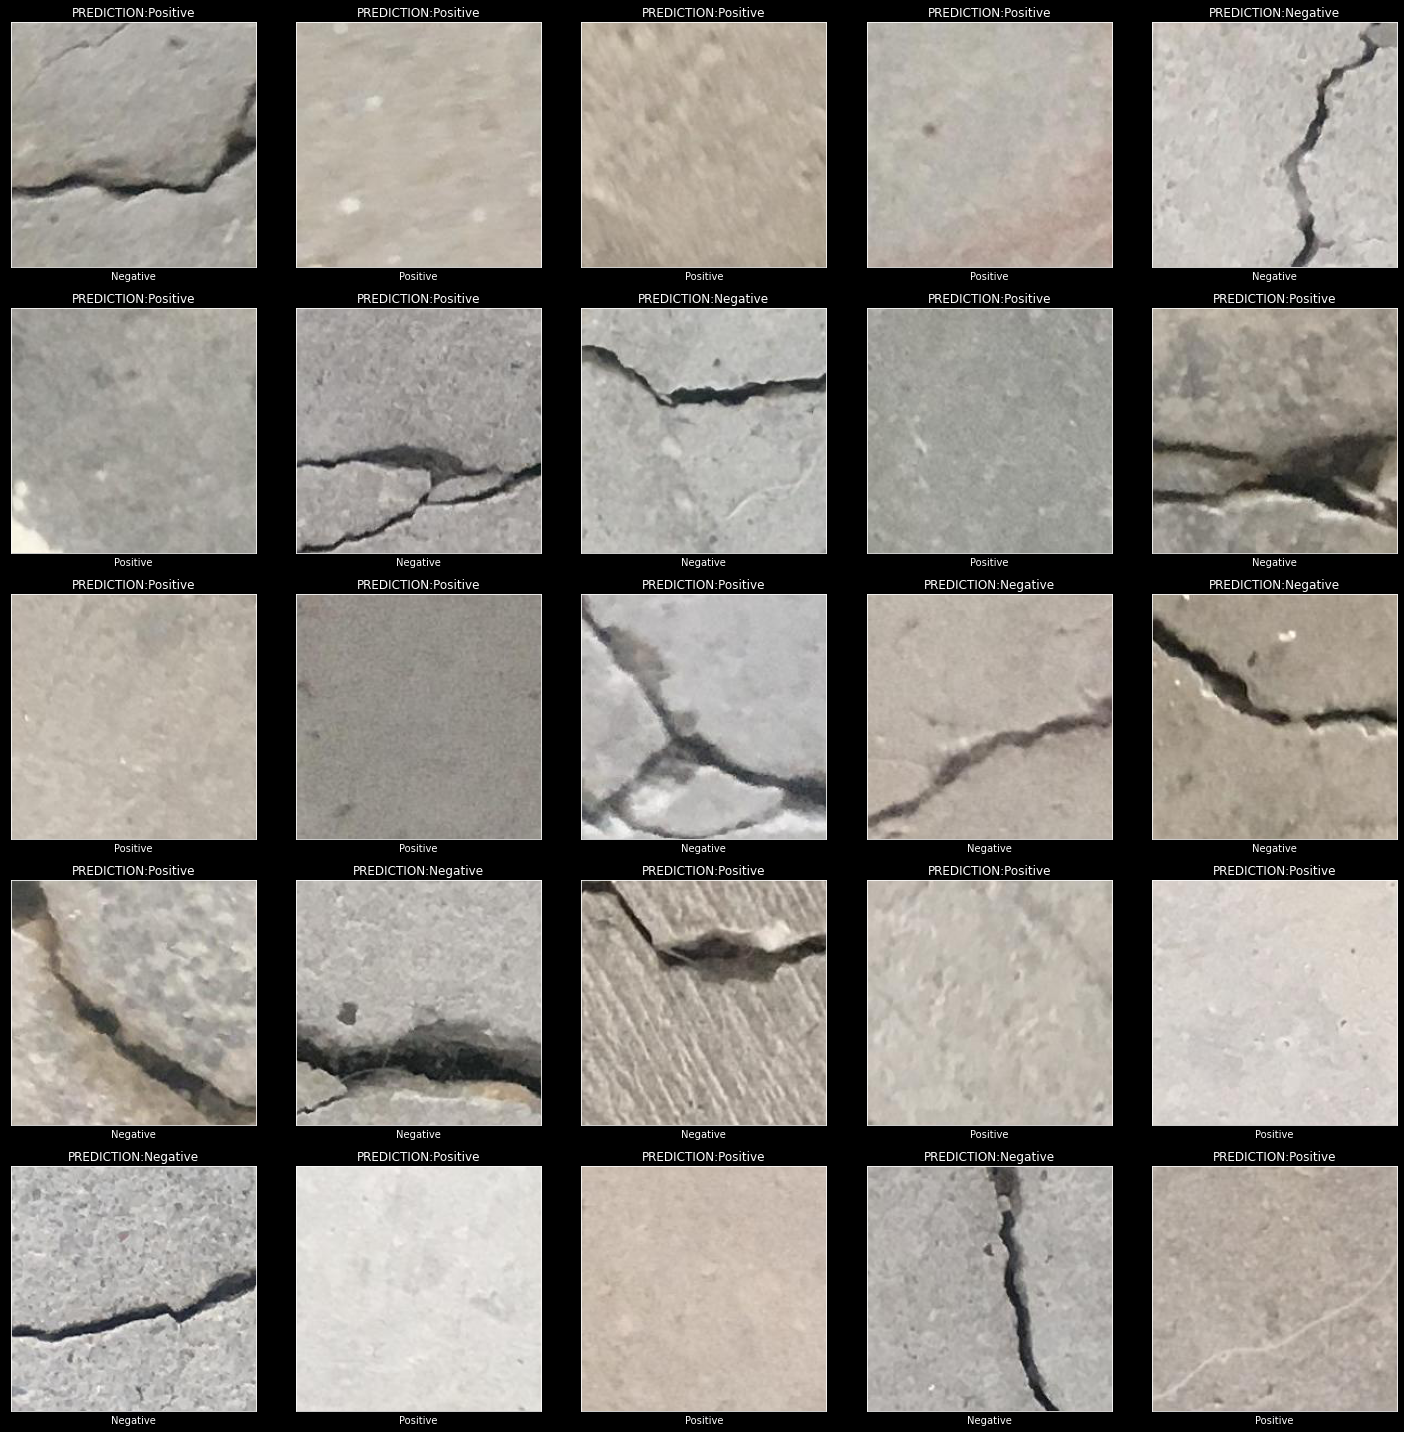

In [107]:
real_labels_list = list(rounded_labels_real.flatten())
fig, axes = plt.subplots(nrows=5,
                         ncols=5,
                         figsize=(20, 20),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(list(testX["JPG"])[idx+i]))
    ax.set_title(f"PREDICTION:{le.inverse_transform([rounded_labels_pred[i]])[0]}")
    ax.set_xlabel(le.inverse_transform([int(real_labels_list[i])])[0])
plt.tight_layout()
plt.show()



We achieve a test accuracy of 95% on a larger dataset and 81% on a smaller dataset.